# Classification with both Physio Data Classes

In [1]:
import pandas as pd
import numpy as np
from pivottablejs import pivot_ui

import sys
sys.path.append('..')  # in order to import modules from my own package
from packageMeinhart import PhysioDataHandler as PDH
from packageMeinhart.functionsMasterProjectMeinhart import print_precision_recall_accuracy
from packageMeinhart.functionsMasterProjectMeinhart import print_misclassified_data_points

# ML modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
PD1 = PDH.PhysioData_SectionFeatures(num_sections=10,
                                     test_subject_ids=1,
                                     train_subject_ids=1,
                                     test_rep_nums=-1,
                                     train_rep_nums=-1,
                                     test_ex_abbrs=-1,
                                     train_ex_abbrs=-1,
                                     with_non_Ex=True,
                                     rot_axis_test_data=0,
                                     rot_angle_test_data=0,
                                     add_noise_test_data=False,
                                     add_noise_train_data=False,
                                     snr_db=20,
                                     csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                                     csv_skiprows=0,
                                     csv_separator=',',
                                     data_base_path='E:\Physio_Data\DataBase_Physio_with_nonEx.db',
                                     print_progress=True,
                                     signal_abbrs=['Acc','Gyr'],
                                     signal_orientations=['x','y','z'],
                                     labels_abbr2num_dict={'RF':0,'RO':1,'RS':2,'LR':3,'BC':4,'TC':5,
                                                           'MP':6,'SA':7,'P1':8,'P2':9,'NE':10},
                                     sub_id_key='subject_id',
                                     num_rep_key='num_rep',
                                     abbreviation_key='abbreviation',
                                     start_time_key='start_time',
                                     stop_time_key='stop_time',
                                     csv_file_key='csv_file',
                                     sampling_rate=256)

In [3]:
pivot_ui(PD1.get_test_data_points(), 
         rows=['abbreviation'], 
         cols=['subject_id', 'num_rep'], 
         outfile_path="PD1_test.html")

In [4]:
pivot_ui(PD1.get_train_data_points(), 
         rows=['abbreviation'], 
         cols=['subject_id', 'num_rep'], 
         outfile_path="PD1_train.html")

In [5]:
# create ML model
#ML_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=40, n_jobs=-1, random_state=42)
ML_model = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True)) # Support Vector Classifier with input scaling
#ML_model = make_pipeline(StandardScaler(), LDA()) # Linear Discriminant Analysis with input scaling
#ML_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, 
#                                                              solver='lbfgs', 
#                                                              multi_class='multinomial',
#                                                              max_iter=1000,
#                                                              n_jobs=-1)) # Logistic Regression with input scaling
#ML_model = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100), 
#                                                         activation='relu', 
#                                                         solver='adam', # 'adam''lbfgs'
#                                                         alpha=0.2, 
#                                                         batch_size='auto', 
#                                                         learning_rate='constant', 
#                                                         learning_rate_init=0.001, 
#                                                         max_iter=500, 
#                                                         shuffle=True, 
#                                                         random_state=42))

# train the model
ML_model.fit(PD1.X_train(), PD1.y_train())

# predict labels
y_pred = ML_model.predict(PD1.X_test())

In [6]:
# show results
print('Model: ' + type(ML_model).__name__ + '\n')
print('Total Accuracy: {:.2f}%\n'.format((accuracy_score(PD1.y_test(), y_pred))*100))
#print_precision_recall_accuracy(y_pred, PD1.y_test())
report = classification_report(PD1.y_test(), y_pred, 
                               labels=np.arange(0,11),
                               target_names=['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2','NE'],
                               sample_weight=None, output_dict=True)
report_df = pd.DataFrame.from_dict(report, orient='index')
display(report_df)
print('')
print_misclassified_data_points(y_pred, PD1.y_test())

Model: Pipeline

Total Accuracy: 98.73%



,precision,recall,f1-score,support
BC,1.000000,1.000000,1.000000,31
LR,1.000000,1.000000,1.000000,30
MP,0.810811,1.000000,0.895522,30
NE,1.000000,0.982801,0.991326,407
P1,1.000000,1.000000,1.000000,30
P2,1.000000,1.000000,1.000000,30
RF,0.966667,0.966667,0.966667,30
RO,0.966667,0.966667,0.966667,30
RS,1.000000,1.000000,1.000000,30
SA,1.000000,1.000000,1.000000,31



9 misclassified (709 test data points):
RF classified as RO
RO classified as RF
NE classified as MP
NE classified as MP
NE classified as MP
NE classified as MP
NE classified as MP
NE classified as MP
NE classified as MP


In [7]:
PD1_wp = PDH.PhysioData_WindowingProcedure(test_subject_dir  = r'E:\Physio_Data\Subject_01',
                                           test_subject_file = 'subject01.csv',
                                           number_sections=10,
                                           signal_abbrs=['Acc','Gyr'],
                                           signal_orientations=['x','y','z'],
                                           sampling_rate=256,
                                           cutoff=10,
                                           order=6,
                                           win_start_inc=0.2,
                                           win_stretch_inc=0.2,
                                           win_min_len=1,
                                           win_max_len=5,
                                           win_start_min_sec='00:00.0', # '22:05.0'
                                           win_last_start_min_sec=None, #'22:44.8',
                                           print_progress=True,
                                           progress_info='Generate feature map...',
                                           rot_axis=0,
                                           rot_angle=0,
                                           add_noise=False,
                                           target_snr_db=20,
                                           csv_skiprows=0,
                                           csv_separator=',',
                                           exercise_abbrs=['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2','NE'],
                                           exercise_abbrs_peak_eval=['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2'])

np.shape(PD1_wp.get_feature_map())

Generate feature map... 100%


(210945, 60)

In [8]:
pred_probs = ML_model.predict_proba(PD1_wp.get_feature_map())
np.shape(pred_probs)

(210945, 11)

In [9]:
PD1_wp.evaluate_probability_matrix(pred_probabilities=pred_probs,
                                   max_time_between_peaks=6,
                                   min_peaks_per_block=3,
                                   threshold_prob=0.6,
                                   footprint_length=3,
                                   print_rep_len_prob=True)


Exercise: RF
Number of blocks: 3

	Block #1:
		Repetitions: 10
		Time range: 13:44.2 - 14:13.2
		Repetition lengths [s] and predicted prob.: 
			  1	2.60	(0.860)
			  2	2.80	(0.876)
			  3	2.80	(0.883)
			  4	2.80	(0.864)
			  5	2.60	(0.898)
			  6	2.60	(0.891)
			  7	2.60	(0.895)
			  8	3.20	(0.784)
			  9	3.20	(0.602)
			 10	2.80	(0.801)
	Block #2:
		Repetitions: 15
		Time range: 14:39.8 - 15:19.2
		Repetition lengths [s] and predicted prob.: 
			  1	2.40	(0.884)
			  2	2.80	(0.896)
			  3	2.80	(0.890)
			  4	2.60	(0.900)
			  5	2.80	(0.873)
			  6	2.60	(0.880)
			  7	2.60	(0.893)
			  8	2.60	(0.892)
			  9	2.40	(0.901)
			 10	2.60	(0.885)
			 11	2.60	(0.910)
			 12	2.40	(0.892)
			 13	2.60	(0.899)
			 14	2.60	(0.886)
			 15	2.60	(0.882)
	Block #3:
		Repetitions: 5
		Time range: 16:08.6 - 16:22.2
		Repetition lengths [s] and predicted prob.: 
			  1	2.60	(0.896)
			  2	2.80	(0.887)
			  3	3.00	(0.892)
			  4	2.60	(0.875)
			  5	2.80	(0.824)

Exercise: RO
Number of blocks: 3

	Block 

In [10]:
%matplotlib auto
PD1_wp.plot_probability_matrices_and_peaks(title_text='Predicted Probabilites Subject 1')

Using matplotlib backend: TkAgg


In [11]:
%matplotlib auto
PD1_wp.plot_probability_matrices_and_peaks(title_text='Predicted Probabilites Subject 1',
                                           default_settings_smaller_plot=True,
                                           plot_time_range=True,
                                           start_time='13:46.0',
                                           stop_time='14:14',
                                           time_offset_before_and_after=1,
                                           plot_actual_classes=True,
                                           timetable_file_dir = r'E:\Physio_Data\Exercise_time_tables',
                                           timetable_file_name = 'Timetable_subject01.txt')

Using matplotlib backend: TkAgg


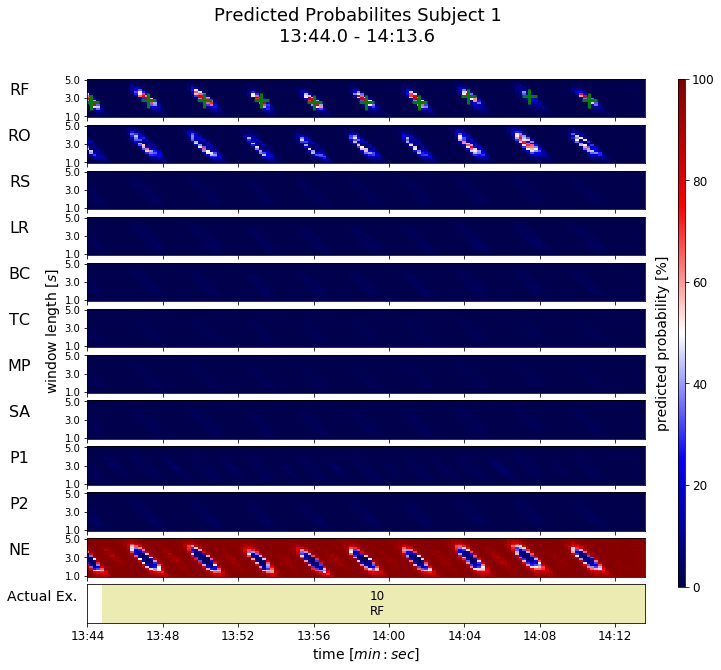

In [12]:
%matplotlib inline
PD1_wp.plot_probability_matrices_and_peaks(title_text='Predicted Probabilites Subject 1',
                                           default_settings_smaller_plot=False,
                                           figsize = (10, 10),
                                           cross_size = 15,
                                           cross_width = 3,
                                           fontsize_title = 18,
                                           yticks_step_in_s = 2,
                                           fontsize_yticks = 10,
                                           fontsize_ylabels_ex = 16,
                                           labelpad_ex = 45,
                                           fontsize_actual_classes = 12,
                                           fontsize_actual_classes_label = 14,
                                           labelpad_actual_classes = 45,
                                           fontsize_window_length = 14,
                                           xpos_window_length = 0.065,
                                           ypos_window_length = 0.6,
                                           fontsize_time_xlabel = 14,
                                           fontsize_time_xticks = 12,
                                           fontsize_pred_prob=14,
                                           xpos_pred_prob=0.915,
                                           ypos_pred_prob=0.62,
                                           colorbar_position_x_y_length_heigth = [0.945, 0.175, 0.01, 0.705],
                                           fontsize_colorbar_ticks = 12,
                                           interactive_plot = False,
                                           plot_time_range=True,
                                           start_time='13:44.0',
                                           stop_time='14:13.6',
                                           time_offset_before_and_after=0,
                                           plot_actual_classes=True,
                                           timetable_file_dir = r'E:\Physio_Data\Exercise_time_tables',
                                           timetable_file_name = 'Timetable_subject01.txt')

In [ ]:

timetable_file_dir = r'E:\Physio_Data\Exercise_time_tables'
timetable_file_name = 'Timetable_subject01.txt'

# dict for exercise names according to the timetable and the corresponding abbreviation
exercise_timetable_names = {'Raises Front':'RF',
                            'Raises Oblique':'RO',
                            'Raises Side':'RS',
                            'Rotation Wrist':'LR',
                            'Biceps Curls':'BC',
                            'Triceps Curls':'TC',
                            'Military Press':'MP',
                            'Shoulder Adduct.':'SA',
                            'PNF Diagonal 1':'P1',
                            'PNF Diagonal 2':'P2'}

# file with timetable (csv) of the test subject
timetable_data_path = os.path.join(timetable_file_dir, timetable_file_name)

# read in time table
timetable_data = pd.read_csv(timetable_data_path, skiprows=0, sep='\t', header=None)
num_exercises = timetable_data.shape[0] # number of exercises

timetable_ex_dict = {}

# going through all exercises in the timetable
for ii, ex_name in enumerate(timetable_data.values[:,0]):

    # going through all repetition blocks in the timetable (5, 10 and 15 rep. blocks)
    for rep_col, start_col, stop_col in zip([1,2,3],[4,6,8],[5,7,9]): # corresponding columns
        
        rep_num = timetable_data.values[ii,rep_col]

        start_time = timetable_data.values[ii,start_col]
        
        stop_time = timetable_data.values[ii,stop_col]
        
        # write stop and start time to dict
        timetable_ex_dict['{}_{}_start_time'.format(exercise_timetable_names[ex_name], rep_num)] = start_time
        timetable_ex_dict['{}_{}_stop_time'.format(exercise_timetable_names[ex_name], rep_num)] = stop_time


In [ ]:
timetable_ex_dict['RF_10_start_time']